<a href="https://colab.research.google.com/github/Winindu/j-s-update/blob/main/j's_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# SECTION A: Install libs, imports, seeds, and drive mount
!pip install -q category_encoders

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

from IPython.display import display

# sklearn / imblearn / tensorflow
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from category_encoders.target_encoder import TargetEncoder

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
FILE_PATH = '/content/drive/MyDrive/ML/Telco Customers.csv'
FIG_DIR = '/content/figures_task2'
os.makedirs(FIG_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# SECTION B: Load data & cleaning
df = pd.read_csv(FILE_PATH)
print("Initial shape:", df.shape)
display(df.head())

# Drop customerID if present
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Fix TotalCharges (blank -> NaN -> numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True), errors='coerce')
df.loc[df['tenure'] == 0, 'TotalCharges'] = df.loc[df['tenure'] == 0, 'TotalCharges'].fillna(0.0)
df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

print("\nAfter cleaning TotalCharges, shape:", df.shape)
display(df.info())

# Add small feature: AvgMonthlyCharges for EDA
df['AvgMonthlyCharges'] = np.where(df['tenure'] > 0, df['TotalCharges'] / df['tenure'], df['MonthlyCharges'])


Initial shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



After cleaning TotalCharges, shape: (7043, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 

None

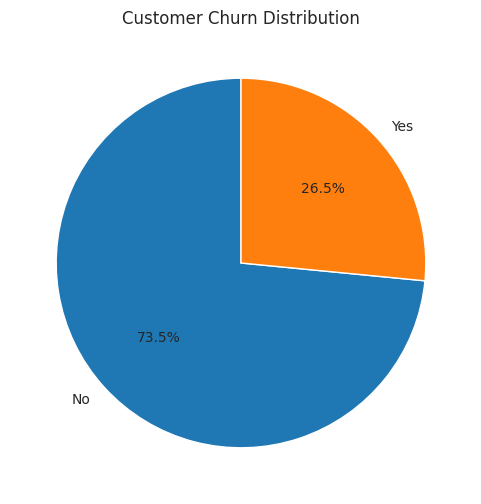

Churn counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn %:
 Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


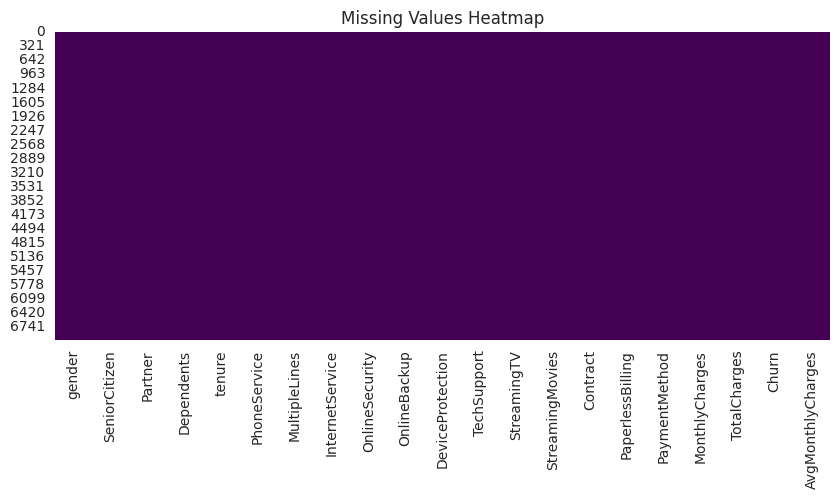

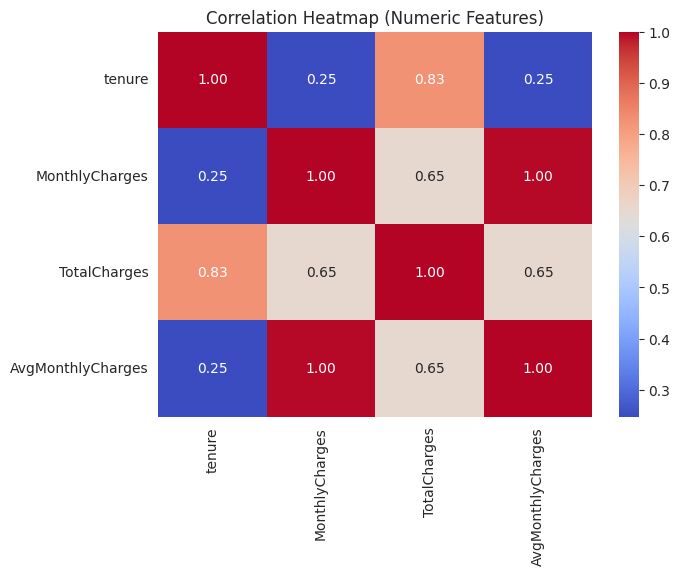

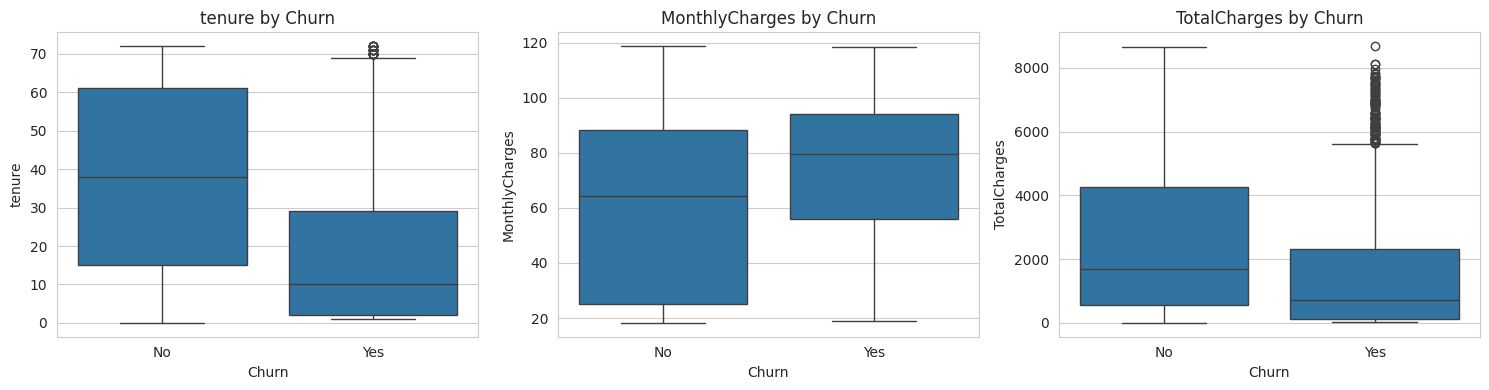

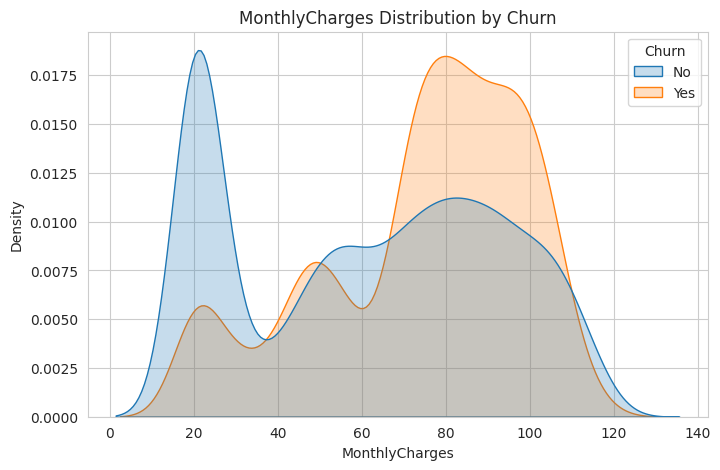

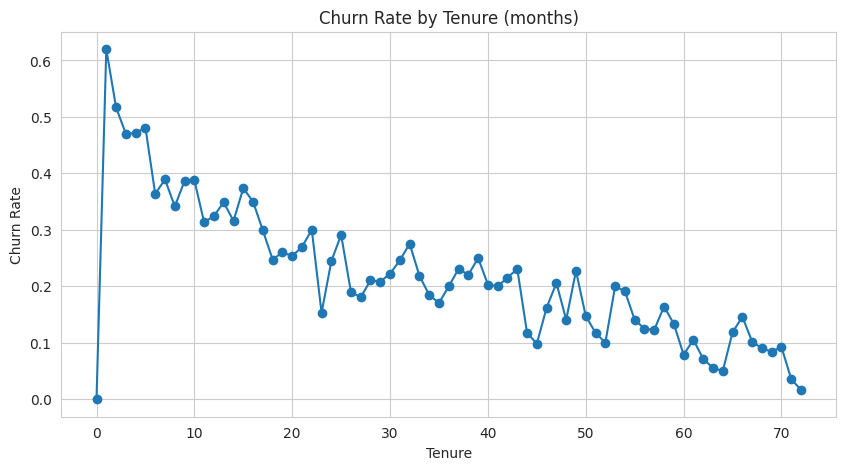

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Churn rate by Contract:
 Contract
Month-to-month    42.71
One year          11.27
Two year           2.83
Name: Churn, dtype: float64

Churn rate by PaymentMethod:
 PaymentMethod
Electronic check             45.29
Mailed check                 19.11
Bank transfer (automatic)    16.71
Credit card (automatic)      15.24
Name: Churn, dtype: float64

Churn rate by InternetService:
 InternetService
Fiber optic    41.89
DSL            18.96
No              7.40
Name: Churn, dtype: float64

Churn rate by SeniorCitizen:
 SeniorCitizen
Yes    41.68
No     23.61
Name: Churn, dtype: float64

Churn rate by PaperlessBilling:
 PaperlessBilling
Yes    33.57
No     16.33
Name: Churn, dtype: float64


In [23]:
# SECTION C: Full EDA (keep for your report)
plt.figure(figsize=(6,6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customer Churn Distribution')
plt.savefig(os.path.join(FIG_DIR, 'churn_pie.png'), dpi=150, bbox_inches='tight')
plt.show()
print("Churn counts:\n", churn_counts)
print("Churn %:\n", churn_counts/len(df)*100)

plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.savefig(os.path.join(FIG_DIR, 'missing_values_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
corr = df[numeric_cols + ['AvgMonthlyCharges']].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.savefig(os.path.join(FIG_DIR, 'numeric_corr.png'), dpi=150, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Churn')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'boxplots_numeric_churn.png'), dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False)
plt.title("MonthlyCharges Distribution by Churn")
plt.savefig(os.path.join(FIG_DIR, 'monthly_charges_kde.png'), dpi=150, bbox_inches='tight')
plt.show()

tenure_churn_rate = df.groupby('tenure')['Churn'].apply(lambda x: (x == 'Yes').mean())
plt.figure(figsize=(10,5))
plt.plot(tenure_churn_rate.index, tenure_churn_rate.values, marker='o')
plt.title("Churn Rate by Tenure (months)")
plt.xlabel("Tenure")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, 'tenure_churn_rate.png'), dpi=150, bbox_inches='tight')
plt.show()

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')
print("Categorical columns:", cat_cols)

# Show churn rate for key categorical features (insight)
insight_cols = ['Contract', 'PaymentMethod', 'InternetService', 'SeniorCitizen', 'PaperlessBilling']
for c in insight_cols:
    if c in df.columns:
        temp = df.copy()
        if c == 'SeniorCitizen' and temp[c].dtype != object:
            temp[c] = temp[c].map({0:'No', 1:'Yes'})
        churn_rate = (temp.groupby(c)['Churn'].apply(lambda x: (x=='Yes').mean())*100).sort_values(ascending=False)
        print(f"\nChurn rate by {c}:\n", churn_rate.round(2))


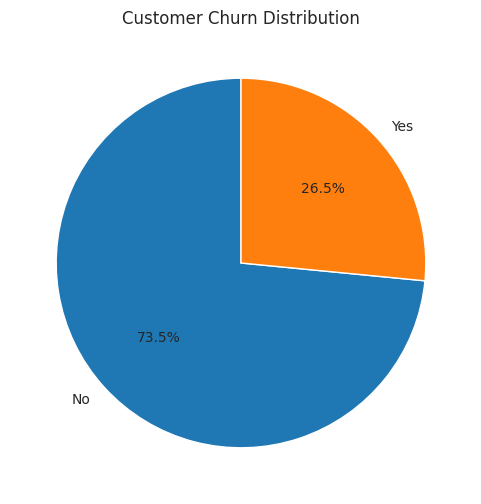

Churn counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn %:
 Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


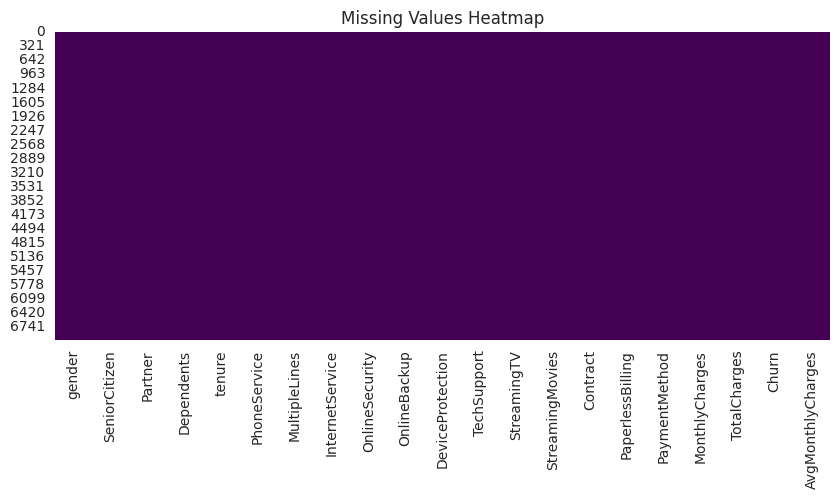

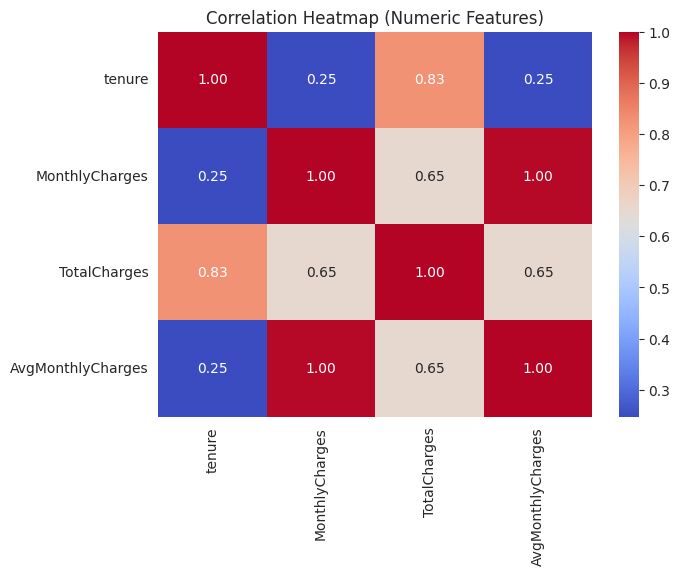

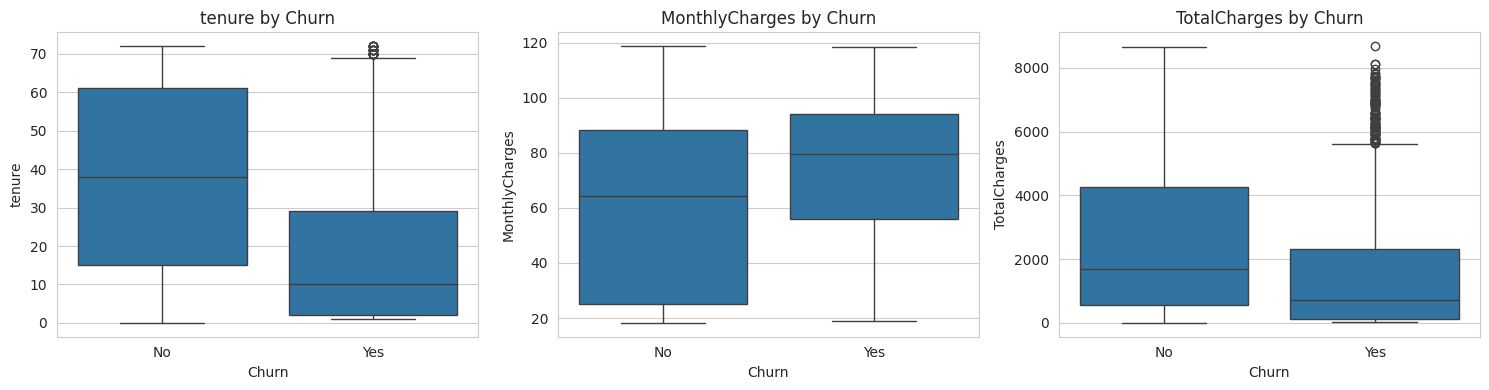

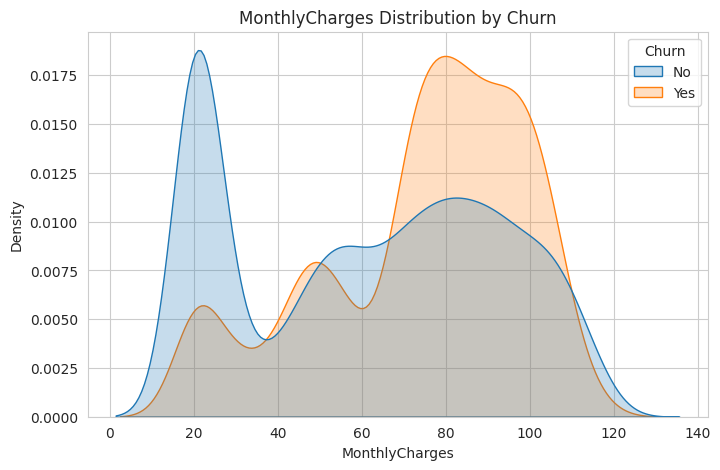

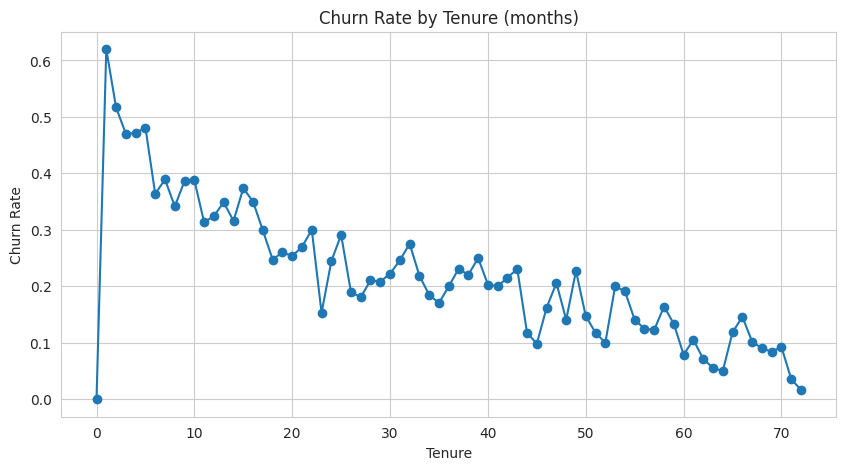

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Churn rate by Contract:
 Contract
Month-to-month    42.71
One year          11.27
Two year           2.83
Name: Churn, dtype: float64

Churn rate by PaymentMethod:
 PaymentMethod
Electronic check             45.29
Mailed check                 19.11
Bank transfer (automatic)    16.71
Credit card (automatic)      15.24
Name: Churn, dtype: float64

Churn rate by InternetService:
 InternetService
Fiber optic    41.89
DSL            18.96
No              7.40
Name: Churn, dtype: float64

Churn rate by SeniorCitizen:
 SeniorCitizen
Yes    41.68
No     23.61
Name: Churn, dtype: float64

Churn rate by PaperlessBilling:
 PaperlessBilling
Yes    33.57
No     16.33
Name: Churn, dtype: float64


In [24]:
# SECTION C: Full EDA (keep for your report)
plt.figure(figsize=(6,6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customer Churn Distribution')
plt.savefig(os.path.join(FIG_DIR, 'churn_pie.png'), dpi=150, bbox_inches='tight')
plt.show()
print("Churn counts:\n", churn_counts)
print("Churn %:\n", churn_counts/len(df)*100)

plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.savefig(os.path.join(FIG_DIR, 'missing_values_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
corr = df[numeric_cols + ['AvgMonthlyCharges']].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.savefig(os.path.join(FIG_DIR, 'numeric_corr.png'), dpi=150, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Churn')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'boxplots_numeric_churn.png'), dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False)
plt.title("MonthlyCharges Distribution by Churn")
plt.savefig(os.path.join(FIG_DIR, 'monthly_charges_kde.png'), dpi=150, bbox_inches='tight')
plt.show()

tenure_churn_rate = df.groupby('tenure')['Churn'].apply(lambda x: (x == 'Yes').mean())
plt.figure(figsize=(10,5))
plt.plot(tenure_churn_rate.index, tenure_churn_rate.values, marker='o')
plt.title("Churn Rate by Tenure (months)")
plt.xlabel("Tenure")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, 'tenure_churn_rate.png'), dpi=150, bbox_inches='tight')
plt.show()

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')
print("Categorical columns:", cat_cols)

# Show churn rate for key categorical features (insight)
insight_cols = ['Contract', 'PaymentMethod', 'InternetService', 'SeniorCitizen', 'PaperlessBilling']
for c in insight_cols:
    if c in df.columns:
        temp = df.copy()
        if c == 'SeniorCitizen' and temp[c].dtype != object:
            temp[c] = temp[c].map({0:'No', 1:'Yes'})
        churn_rate = (temp.groupby(c)['Churn'].apply(lambda x: (x=='Yes').mean())*100).sort_values(ascending=False)
        print(f"\nChurn rate by {c}:\n", churn_rate.round(2))


In [25]:
# SECTION D: Preprocessing (Target Encoding + Scaling) + Train/Val/Test split + SMOTE

# Prepare X, y and split (do this AFTER EDA)
X = df.drop(columns=['Churn'])
y = df['Churn'].map({'No':0, 'Yes':1}).astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))
print("Train churn %:", y_train.mean())

# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Keep SeniorCitizen numeric (do not target-encode binary numeric)
if 'SeniorCitizen' in cat_cols:
    # If SeniorCitizen was object for some reason, move it to numeric - convert to 0/1
    try:
        X_train['SeniorCitizen'] = X_train['SeniorCitizen'].astype(int)
        X_val['SeniorCitizen'] = X_val['SeniorCitizen'].astype(int)
        X_test['SeniorCitizen'] = X_test['SeniorCitizen'].astype(int)
        if 'SeniorCitizen' in cat_cols:
            cat_cols.remove('SeniorCitizen')
    except Exception:
        # if conversion fails, keep it categorical; else remove it:
        pass

print("Numeric cols:", num_cols)
print("Categorical cols to target-encode:", cat_cols)

# Target encoding for categorical columns
te = TargetEncoder(cols=cat_cols, smoothing=0.3)
X_train_cat_enc = te.fit_transform(X_train[cat_cols], y_train)
X_val_cat_enc = te.transform(X_val[cat_cols])
X_test_cat_enc = te.transform(X_test[cat_cols])

# Scale numeric columns
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
X_val_num_scaled = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

# Combine numeric+encoded categorical back to DataFrames
X_train_prep = pd.concat([X_train_num_scaled.reset_index(drop=True), X_train_cat_enc.reset_index(drop=True)], axis=1)
X_val_prep = pd.concat([X_val_num_scaled.reset_index(drop=True), X_val_cat_enc.reset_index(drop=True)], axis=1)
X_test_prep = pd.concat([X_test_num_scaled.reset_index(drop=True), X_test_cat_enc.reset_index(drop=True)], axis=1)

print("Shapes after encoding+scaling:", X_train_prep.shape, X_val_prep.shape, X_test_prep.shape)

# Save feature names for DT visualization
feature_names = X_train_prep.columns.tolist()

# SMOTE only on training set
sm = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train_prep, y_train)
print("After SMOTE — train shape:", X_train_bal.shape, "Churn%:", y_train_bal.mean())

# Convert to numpy arrays for TF if necessary (TensorFlow accepts numpy arrays)
X_train_bal = np.asarray(X_train_bal)
X_val_prep = np.asarray(X_val_prep)
X_test_prep = np.asarray(X_test_prep)


Train/Val/Test sizes: 4930 1056 1057
Train churn %: 0.2653144016227181
Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges']
Categorical cols to target-encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Shapes after encoding+scaling: (4930, 20) (1056, 20) (1057, 20)
After SMOTE — train shape: (7244, 20) Churn%: 0.5


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best DT params: {'ccp_alpha': 0.005, 'max_depth': 4, 'min_samples_leaf': 40, 'min_samples_split': 20}
Best DT CV F1: 0.774408002670623

Decision Tree Test metrics:
Accuracy: 0.7474, Precision: 0.5206, Recall: 0.6299, F1: 0.5700, AUC: 0.7856
Confusion Matrix:
 [[613 163]
 [104 177]]


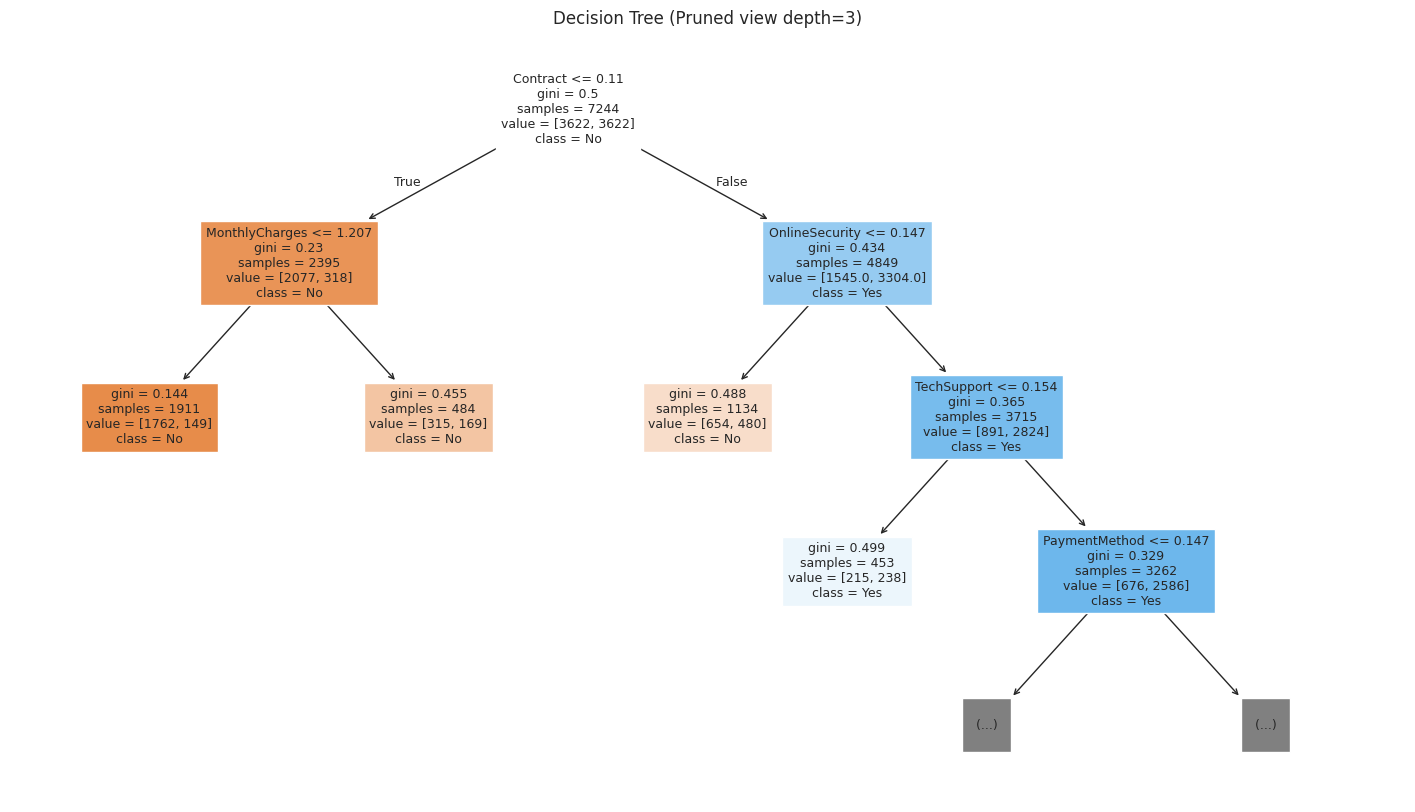

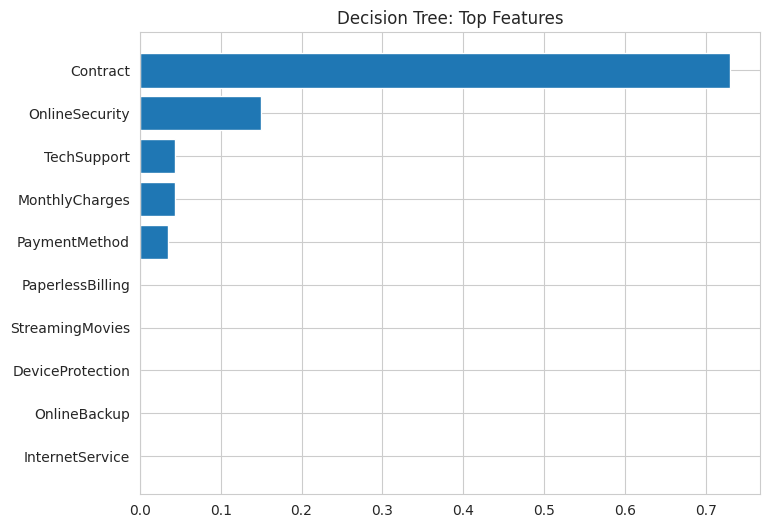

In [26]:
# SECTION E: Decision Tree tuning + evaluation

from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
# param_grid = {
#    'max_depth' : [3, 4, 5, 6],
#    'min_samples_leaf' : [10, 20, 30],
#    'min_samples_split' : [10, 20],
#    'criterion' : ['gini'],
#    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]
# }
param_grid = {
   'max_depth' : [2, 3, 4],
   'min_samples_leaf' : [20, 40, 60],
   'min_samples_split' : [20, 40],
   'ccp_alpha': [0.005, 0.01, 0.02]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
grid_dt = GridSearchCV(dt, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_dt.fit(X_train_bal, y_train_bal)

best_dt = grid_dt.best_estimator_
print("Best DT params:", grid_dt.best_params_)
print("Best DT CV F1:", grid_dt.best_score_)

# Evaluate on test
y_pred_dt = best_dt.predict(X_test_prep)
y_proba_dt = best_dt.predict_proba(X_test_prep)[:,1]

dt_acc = accuracy_score(y_test, y_pred_dt)
dt_prec, dt_rec, dt_f1, _ = precision_recall_fscore_support(y_test, y_pred_dt, average='binary')
dt_auc = roc_auc_score(y_test, y_proba_dt)
print("\nDecision Tree Test metrics:")
print(f"Accuracy: {dt_acc:.4f}, Precision: {dt_prec:.4f}, Recall: {dt_rec:.4f}, F1: {dt_f1:.4f}, AUC: {dt_auc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# Plot pruned view (depth 3)
plt.figure(figsize=(18,10))
plot_tree(best_dt, max_depth=3, feature_names=feature_names, class_names=['No','Yes'], filled=True, fontsize=9)
plt.title("Decision Tree (Pruned view depth=3)")
plt.savefig(os.path.join(FIG_DIR, 'dt_tree_depth3.png'), dpi=150, bbox_inches='tight')
plt.show()

# Feature importances
importances = best_dt.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Decision Tree: Top Features")
plt.savefig(os.path.join(FIG_DIR, 'dt_feature_importances.png'), dpi=150, bbox_inches='tight')
plt.show()


In [27]:
# SECTION F: ANN hyperparameter manual search and final training

n_features = X_train_bal.shape[1]

def build_ann(units1=64, units2=32, dropout1=0.3, dropout2=0.2, lr=1e-3):
    model = Sequential()
    model.add(Dense(units1, activation='relu', input_shape=(n_features,)))
    if dropout1>0:
        model.add(Dropout(dropout1))
    model.add(Dense(units2, activation='relu'))
    if dropout2>0:
        model.add(Dropout(dropout2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

hp_grid = [
    {'units1':64,  'units2':32,  'dropout1':0.3, 'dropout2':0.2, 'lr':1e-3, 'batch_size':32},
    {'units1':128, 'units2':64,  'dropout1':0.4, 'dropout2':0.3, 'lr':1e-3, 'batch_size':32},
    {'units1':32,  'units2':16,  'dropout1':0.2, 'dropout2':0.1, 'lr':5e-4, 'batch_size':64},
]

best_hp = None
best_val_auc = -np.inf
results_hp = []

# Convert y_train_bal to numpy array if not already
y_train_bal = np.asarray(y_train_bal)

for hp in hp_grid:
    print(f"\nTraining with HP: {hp}")
    model_hp = build_ann(units1=hp['units1'], units2=hp['units2'],
                         dropout1=hp['dropout1'], dropout2=hp['dropout2'],
                         lr=hp['lr'])
    early_stop = EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True, mode='max', verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=0)
    hist = model_hp.fit(X_train_bal, y_train_bal, validation_data=(X_val_prep, y_val),
                        epochs=60, batch_size=hp['batch_size'], callbacks=[early_stop, reduce_lr], verbose=0)
    val_auc = max(hist.history['val_auc'])
    val_acc = hist.history['val_accuracy'][np.argmax(hist.history['val_auc'])]
    print(f"→ Val AUC: {val_auc:.4f}, Val Acc@bestAUC: {val_acc:.4f}, Epochs trained: {len(hist.history['loss'])}")
    results_hp.append({'hp':hp, 'val_auc':val_auc, 'val_acc':val_acc})
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_hp = hp
        best_model = model_hp

print("\nBest ANN HP:", best_hp, "Best Val AUC:", best_val_auc)

# Final training with callbacks
final_model = build_ann(units1=best_hp['units1'], units2=best_hp['units2'],
                        dropout1=best_hp['dropout1'], dropout2=best_hp['dropout2'],
                        lr=best_hp['lr'])

early_stop = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = final_model.fit(X_train_bal, y_train_bal, validation_data=(X_val_prep, y_val),
                          epochs=200, batch_size=best_hp['batch_size'],
                          callbacks=[early_stop, reduce_lr], verbose=1)

final_model.save('/content/drive/MyDrive/ML/final_ann_model.h5')



Training with HP: {'units1': 64, 'units2': 32, 'dropout1': 0.3, 'dropout2': 0.2, 'lr': 0.001, 'batch_size': 32}
→ Val AUC: 0.8491, Val Acc@bestAUC: 0.7509, Epochs trained: 15

Training with HP: {'units1': 128, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.3, 'lr': 0.001, 'batch_size': 32}
→ Val AUC: 0.8474, Val Acc@bestAUC: 0.7509, Epochs trained: 12

Training with HP: {'units1': 32, 'units2': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'lr': 0.0005, 'batch_size': 64}
→ Val AUC: 0.8464, Val Acc@bestAUC: 0.7434, Epochs trained: 48

Best ANN HP: {'units1': 64, 'units2': 32, 'dropout1': 0.3, 'dropout2': 0.2, 'lr': 0.001, 'batch_size': 32} Best Val AUC: 0.8490588068962097
Epoch 1/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6418 - auc: 0.7042 - loss: 0.6166 - val_accuracy: 0.7235 - val_auc: 0.8244 - val_loss: 0.5172 - learning_rate: 0.0010
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7353 - auc: 0.8109 - loss: 0.5285 - val_accuracy: 0.7377 - val_auc: 0.8347 - 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Test Set Summary ---


,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree,0.7474,0.5206,0.6299,0.5700,0.7856
1,Neural Network,0.7559,0.5294,0.7367,0.6161,0.8391



Decision Tree Confusion Matrix:
 [[613 163]
 [104 177]]

Neural Network Confusion Matrix:
 [[592 184]
 [ 74 207]]


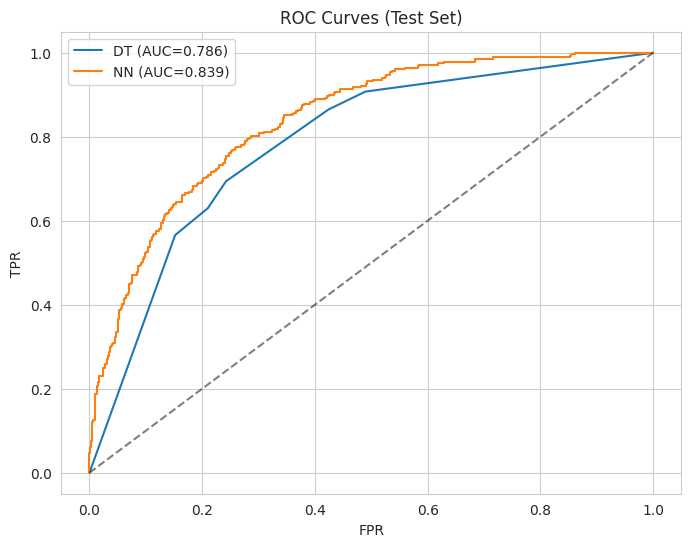

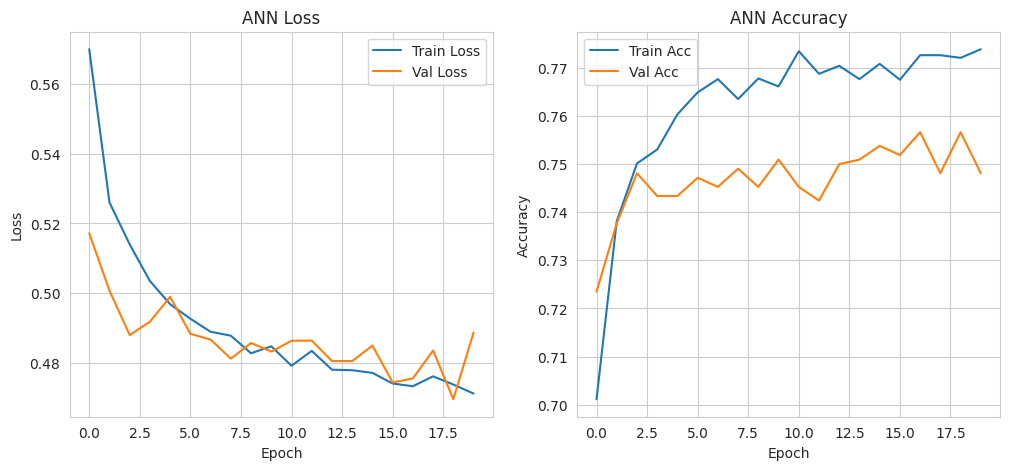


--- Train vs Test Accuracy Comparison ---
Decision Tree → Train: 0.7674, Test: 0.7474, Gap: 0.0200
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network → Train: 0.7762, Test: 0.7559, Gap: 0.0203
✅ Decision Tree overfitting is minimal.
✅ Neural Network overfitting is minimal.


In [28]:
# SECTION G: Evaluate both models on the TEST set and diagnostic plots

# Decision Tree predictions already made in Section E
y_pred_dt = best_dt.predict(X_test_prep)
y_proba_dt = best_dt.predict_proba(X_test_prep)[:,1]

# ANN predictions
y_proba_nn = final_model.predict(X_test_prep).flatten()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

def get_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)
    return {'Accuracy':acc, 'Precision':prec, 'Recall':rec, 'F1':f1, 'AUC':auc, 'CM':cm}

dt_metrics = get_metrics(y_test, y_pred_dt, y_proba_dt)
nn_metrics = get_metrics(y_test, y_pred_nn, y_proba_nn)

results_df = pd.DataFrame([
    {'Model':'Decision Tree', **{k:v for k,v in dt_metrics.items() if k!='CM'}},
    {'Model':'Neural Network', **{k:v for k,v in nn_metrics.items() if k!='CM'}}
])
print("\n--- Test Set Summary ---")
display(results_df.round(4))

print("\nDecision Tree Confusion Matrix:\n", dt_metrics['CM'])
print("\nNeural Network Confusion Matrix:\n", nn_metrics['CM'])

# ROC comparison
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={dt_metrics["AUC"]:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC={nn_metrics["AUC"]:.3f})')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves (Test Set)')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, 'roc_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

# Training curves for ANN
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ANN Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('ANN Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, 'ann_train_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

# Overfitting diagnostics
# train_acc_dt = accuracy_score(y_train_bal, best_dt.predict(X_train_bal))
# test_acc_dt = dt_metrics['Accuracy']
# train_acc_nn = history.history['accuracy'][-1]
# test_acc_nn = nn_metrics['Accuracy']

# print("\n--- Overfitting diagnostics ---")
# print(f"Decision Tree — Train Acc: {train_acc_dt:.4f}, Test Acc: {test_acc_dt:.4f}, Gap: {train_acc_dt - test_acc_dt:.4f}")
# print(f"Neural Network — Train Acc: {train_acc_nn:.4f}, Test Acc: {test_acc_nn:.4f}, Gap: {train_acc_nn - test_acc_nn:.4f}")

# if (abs(train_acc_dt - test_acc_dt) > 0.05):
#     print("DT shows potential overfitting. Consider stronger pruning or ensemble models (RandomForest/CatBoost).")
# else:
#     print("DT overfitting gap acceptable by simple rule-of-thumb.")
# --- Correct Train/Test Accuracy for BOTH MODELS ---

print("\n--- Train vs Test Accuracy Comparison ---")

# 1️⃣ Decision Tree
train_acc_dt = accuracy_score(y_train_bal, best_dt.predict(X_train_bal))
test_acc_dt  = dt_metrics['Accuracy']
dt_gap = train_acc_dt - test_acc_dt

print(f"Decision Tree → Train: {train_acc_dt:.4f}, Test: {test_acc_dt:.4f}, Gap: {dt_gap:.4f}")

# 2️⃣ Neural Network
# Compute training accuracy directly on X_train_bal
y_pred_train_nn = (final_model.predict(X_train_bal) >= 0.5).astype(int).flatten()
train_acc_nn = accuracy_score(y_train_bal, y_pred_train_nn)

test_acc_nn = nn_metrics['Accuracy']
nn_gap = train_acc_nn - test_acc_nn

print(f"Neural Network → Train: {train_acc_nn:.4f}, Test: {test_acc_nn:.4f}, Gap: {nn_gap:.4f}")

# Interpretation
if abs(dt_gap) > 0.05:
    print("⚠️ Decision Tree shows overfitting.")
else:
    print("✅ Decision Tree overfitting is minimal.")

if abs(nn_gap) > 0.05:
    print("⚠️ Neural Network shows overfitting.")
else:
    print("✅ Neural Network overfitting is minimal.")




In [29]:
# SECTION H: Bias checks, save artifacts, and summary

# Gender bias check (DT predictions)
df_test = X_test.copy().reset_index(drop=True)  # original X_test DataFrame before encoding
df_test['Churn_numeric'] = y_test.reset_index(drop=True)
df_test['predicted_dt'] = y_pred_dt

male_acc = accuracy_score(df_test[df_test['gender']=='Male']['Churn_numeric'], df_test[df_test['gender']=='Male']['predicted_dt'])
female_acc = accuracy_score(df_test[df_test['gender']=='Female']['Churn_numeric'], df_test[df_test['gender']=='Female']['predicted_dt'])
print("\n--- Gender Bias Check (DT) ---")
print("Male prediction accuracy   :", male_acc)
print("Female prediction accuracy :", female_acc)

# Save models and processors
joblib.dump(best_dt, '/content/drive/MyDrive/ML/best_decision_tree.pkl')
joblib.dump(final_model, '/content/drive/MyDrive/ML/final_ann_model_tf.pkl')  # keras model saved earlier; this saves reference
joblib.dump(te, '/content/drive/MyDrive/ML/target_encoder.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/ML/standard_scaler.pkl')

print("Saved: best_decision_tree.pkl, final_ann_model_tf.pkl (keras model also saved via model.save), target_encoder.pkl, standard_scaler.pkl")

# Save results CSV
results_df.to_csv('/content/drive/MyDrive/ML/model_comparison_results.csv', index=False)

# Short summary for report
print("\n--- Short summary (copy to report) ---")
print(f"Dataset: {FILE_PATH} — {df.shape[0]} rows, {df.shape[1]} columns (after cleaning)")
print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")
print("Preprocessing: StandardScaler on numeric features; TargetEncoder on categorical features (no one-hot).")
print("Balancing: SMOTE applied on training set only.")
print("Decision Tree: GridSearchCV tuned hyperparameters with pruning (ccp_alpha) and class_weight='balanced'.")
print("Neural Network: Manual HP search across layer sizes, dropout rates and learning rates; final ANN saved.")
print("Evaluation metrics saved to model_comparison_results.csv and figures in", FIG_DIR)



--- Gender Bias Check (DT) ---
Male prediction accuracy   : 0.7916666666666666
Female prediction accuracy : 0.699009900990099
Saved: best_decision_tree.pkl, final_ann_model_tf.pkl (keras model also saved via model.save), target_encoder.pkl, standard_scaler.pkl

--- Short summary (copy to report) ---
Dataset: /content/drive/MyDrive/ML/Telco Customers.csv — 7043 rows, 21 columns (after cleaning)
Train/Val/Test sizes: 4930 / 1056 / 1057
Preprocessing: StandardScaler on numeric features; TargetEncoder on categorical features (no one-hot).
Balancing: SMOTE applied on training set only.
Decision Tree: GridSearchCV tuned hyperparameters with pruning (ccp_alpha) and class_weight='balanced'.
Neural Network: Manual HP search across layer sizes, dropout rates and learning rates; final ANN saved.
Evaluation metrics saved to model_comparison_results.csv and figures in /content/figures_task2
